# **Analytics for Unstructured Data: Group Assignment #2**

Akshay Navaneetha Krishnan (an34244)  
Bhuvana Chandrika Kothapalli (bk24542)  
Dinesh Bandaru (db46729)  
Ashwanth Draksha (ad55293)  
Jahnavi Angati (ja54632)

## **Building a Crowdsourced Recommender System**
**High level description:** The objective of this group assignment is to create the building blocks of a crowdsourced recommender system. It should accept user inputs in the form of desired attributes of a product and come up with 3 recommendations.

Obtain reviews of craft beers from beeradvocate.com. I would suggest using the following link, which shows the top 250 beers sorted by ratings:
https://www.beeradvocate.com/beer/top-rated/

The nice feature of the above link is that it is a single-page listing of 250 top-rated beers (avoids the pagination feature, which you need in cases where listings go on for many pages). The way beeradvocate.com organizes reviews is that it provides about 25 reviews per page. The output file should have 3 columns: product_name, product_review, and user_rating.

# Importing Libraries

In [ ]:
# Importing libraries

!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

import pandas as pd
import string
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from itertools import combinations
from sklearn.manifold import MDS
from itertools import product
import seaborn as sns
from google.colab import files
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
stopwords = stopwords.words('english')
import time
import random
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import string

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
chromium-chromedriver is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.
cp: '/u

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Task A.**
Extract about 5-6k reviews

In [ ]:
driver = webdriver.Chrome(options=chrome_options)

In [ ]:
# Function to log in to BeerAdvocate
def login_to_beer_advocate():
    print("Attempting to log in...")
    login_url = "https://www.beeradvocate.com/community/login/"
    driver.get(login_url)
    driver.maximize_window()
    print("Page maximized...")

    user_email = "emailid"
    user_password = "Password"

    while True:
        try:
            WebDriverWait(driver, 30).until(EC.element_to_be_clickable((By.CSS_SELECTOR, 'form#pageLogin input#ctrl_pageLogin_login'))).send_keys(user_email)
            driver.find_element(By.CSS_SELECTOR, 'form#pageLogin input#ctrl_pageLogin_password').send_keys(user_password)
            driver.find_element(By.CSS_SELECTOR, 'form#pageLogin input[type=submit]').click()
            print("Logged in successfully!")
            break
        except TimeoutException:
            print("Login timeout", TimeoutException)

# Function to fetch top-rated beer links
def get_top_rated_links():
    print("Fetching top-rated beer links...")
    top_beers_url = "https://www.beeradvocate.com/beer/top-rated/"
    driver.get(top_beers_url)

    link_dict = {}

    link_elements = driver.find_elements(By.CSS_SELECTOR, 'a[href^="/beer/profile/"] > b')
    for element in link_elements:
        beer_name = element.text
        beer_link = driver.execute_script("return arguments[0].parentNode.href;", element)
        link_dict[beer_name] = beer_link

    print(f"Extracted {len(link_dict)} top-rated beer links.")
    return link_dict

# Function to scrape reviews for a list of beer names
def scrape_reviews_for_beers(names_list):
    top_rated_links = get_top_rated_links()
    scraped_reviews = []
    total_iterations = 250
    with tqdm(total=total_iterations, desc="Processing") as pbar:

      for beer_name in names_list:
          print(f"Scraping reviews for {beer_name}...")
          beer_link = top_rated_links.get(beer_name)
          if not beer_link:
              print(f"Could not find a link for beer: {beer_name}")
              continue

          non_empty_reviews_count = 0
          page_number = 0
          previous_page_source = None

          while non_empty_reviews_count < 25:
              if page_number > 1000:
                  print(f"Reached 50 pages for {beer_name} but did not find 25 non-empty reviews. Moving to the next beer.")
                  break

              driver.get(f"{beer_link}?view=beer&show=recent&start={page_number}#lists")
              #print(page_number)
              time.sleep(random.randint(1, 3))

              current_page_source = driver.page_source

              if current_page_source == previous_page_source:
                  print(f"Reached the last available page for {beer_name}. Moving to the next beer.")
                  break

              soup = BeautifulSoup(current_page_source, 'html.parser')
              review_containers = soup.find_all('div', {'id': 'rating_fullview_container'})

              for container in review_containers:
                  try:
                      username = container.find('a', class_='username').text.strip()
                      # Scraping the location of the reviewer
                      location_parts = container.find('span', class_='muted').text.split('from')
                      location = location_parts[-1].strip() if len(location_parts) > 1 else None
                      rating = None
                      # Scraping the beer rating
                      rating_tag = container.find('b')
                      if rating_tag and 'Rated:' in rating_tag.previous_sibling:
                          rating = rating_tag.text
                      else:
                          score_norm = container.find('span', class_='BAscore_norm')
                          ravg_norm = container.find('span', class_='rAvg_norm')
                          if score_norm and ravg_norm:
                              rating = score_norm.text + ravg_norm.text
                      # Scraping the review date
                      date = container.find_all('span', class_='muted')[-1].a.text
                      # Scraping the review text
                      review_div = container.find('div', style="margin:20px 0px; font-size:11pt; line-height:1.4;")
                      review = review_div.text.strip() if review_div else None

                      if review:
                          non_empty_reviews_count += 1

                          scraped_reviews.append({
                              "Beer": beer_name,
                              "Username": username,
                              "Location": location,
                              "Rating": rating,
                              "Review": review,
                              "Date": date
                          })

                      if non_empty_reviews_count == 25:
                          break
                  except Exception as e:
                      print(f"Error processing review for {beer_name}: {e}")

              #print(f"{non_empty_reviews_count} non-empty reviews scraped for {beer_name} from page {page_number}.")
              page_number += 20
              previous_page_source = current_page_source
          print(len(scraped_reviews))
          pbar.update(1)

    return scraped_reviews

# Function to get the first N top-rated beers
def get_first_n_beers(num_beers):
    top_rated_links = get_top_rated_links()
    return list(top_rated_links.keys())[:num_beers]

beer_list_to_scrape = get_first_n_beers(250)

print(beer_list_to_scrape)

Fetching top-rated beer links...
Extracted 249 top-rated beer links.
['Kentucky Brunch Brand Stout', 'Vanilla Bean Assassin', 'Marshmallow Handjee', 'Abraxas - Barrel-Aged', "Hunahpu's Imperial Stout - Double Barrel Aged", 'Blessed', 'Heady Topper', 'O.W.K.', "Mornin' Delight", 'King Julius', 'A Deal With The Devil - Triple Oak-Aged', 'King JJJuliusss', 'Zenne Y Frontera', 'Pliny The Younger', 'Coconut Vibes - Barrel-Aged', 'Barrel Aged Imperial German Chocolate Cupcake Stout', 'Fundamental Observation', 'Very Hazy', 'Bourbon County Brand Coffee Stout', 'V.S.O.J.', 'Oude Fermier', 'A Deal With The Devil - Double Oak-Aged', 'Clover', 'Anabasis', 'Chemtrailmix - Rye Barrel', 'Double Barrel V.S.O.J.', 'Julius', "Fou' Foune", 'Monster Tones', 'Very Green', 'Assassin', 'Juice Machine', 'Very GGGreennn', 'Westly', 'It Was All A Dream', 'Pliny The Elder', 'CBS (Canadian Breakfast Stout)', 'Samuel', 'Abner', 'Framboise Du Fermier', 'Double Sunshine', 'JJJuliusss!', 'Speedway Stout - Vietnamese

In [ ]:
import csv
# Main function to execute the scraping and data saving
def main():
    login_to_beer_advocate()
    # Get the list of desired beers to scrape
    desired_beers = beer_list_to_scrape
    # Scrape reviews for the desired beers
    scraped_reviews = scrape_reviews_for_beers(beer_list_to_scrape)
    driver.quit()
    print("WebDriver closed...")
    # Save the scraped data to a CSV file
    with open('beer_reviews.csv', 'w', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=["Beer", "Username", "Location", "Rating", "Review", "Date"])
            writer.writeheader()
            writer.writerows(scraped_reviews)
            print("Results saved to beer_reviews.csv")

# Entry point of the script
if __name__ == '__main__':
    main()

Attempting to log in...
Page maximized...
Logged in successfully!
Fetching top-rated beer links...
Extracted 249 top-rated beer links.


Processing:   0%|          | 0/250 [00:00<?, ?it/s]

Scraping reviews for Kentucky Brunch Brand Stout...


Processing:   0%|          | 1/250 [00:15<1:02:54, 15.16s/it]

25
Scraping reviews for Vanilla Bean Assassin...


Processing:   1%|          | 2/250 [00:44<1:36:55, 23.45s/it]

50
Scraping reviews for Marshmallow Handjee...


Processing:   1%|          | 3/250 [01:02<1:26:19, 20.97s/it]

75
Scraping reviews for Abraxas - Barrel-Aged...


Processing:   2%|▏         | 4/250 [01:22<1:25:03, 20.75s/it]

100
Scraping reviews for Hunahpu's Imperial Stout - Double Barrel Aged...


Processing:   2%|▏         | 5/250 [01:50<1:35:13, 23.32s/it]

125
Scraping reviews for Blessed...


Processing:   2%|▏         | 6/250 [02:07<1:26:18, 21.22s/it]

150
Scraping reviews for Heady Topper...


Processing:   3%|▎         | 7/250 [02:22<1:16:59, 19.01s/it]

175
Scraping reviews for O.W.K....


Processing:   3%|▎         | 8/250 [05:50<5:20:08, 79.37s/it]

Reached 50 pages for O.W.K. but did not find 25 non-empty reviews. Moving to the next beer.
184
Scraping reviews for Mornin' Delight...


Processing:   4%|▎         | 9/250 [06:09<4:01:55, 60.23s/it]

209
Scraping reviews for King Julius...


Processing:   4%|▍         | 10/250 [06:24<3:06:09, 46.54s/it]

234
Scraping reviews for A Deal With The Devil - Triple Oak-Aged...


Processing:   4%|▍         | 11/250 [06:46<2:35:17, 38.98s/it]

259
Scraping reviews for King JJJuliusss...


Processing:   5%|▍         | 12/250 [07:09<2:14:23, 33.88s/it]

284
Scraping reviews for Zenne Y Frontera...


Processing:   5%|▌         | 13/250 [07:35<2:04:39, 31.56s/it]

309
Scraping reviews for Pliny The Younger...


Processing:   6%|▌         | 14/250 [07:53<1:48:18, 27.54s/it]

334
Scraping reviews for Coconut Vibes - Barrel-Aged...


Processing:   6%|▌         | 15/250 [11:18<5:17:45, 81.13s/it]

Reached 50 pages for Coconut Vibes - Barrel-Aged but did not find 25 non-empty reviews. Moving to the next beer.
346
Scraping reviews for Barrel Aged Imperial German Chocolate Cupcake Stout...


Processing:   6%|▋         | 16/250 [11:57<4:26:30, 68.33s/it]

371
Scraping reviews for Fundamental Observation...


Processing:   7%|▋         | 17/250 [12:08<3:18:56, 51.23s/it]

396
Scraping reviews for Very Hazy...


Processing:   7%|▋         | 18/250 [12:26<2:39:18, 41.20s/it]

421
Scraping reviews for Bourbon County Brand Coffee Stout...


Processing:   8%|▊         | 19/250 [12:39<2:05:08, 32.51s/it]

446
Scraping reviews for V.S.O.J....


Processing:   8%|▊         | 20/250 [12:52<1:43:13, 26.93s/it]

471
Scraping reviews for Oude Fermier...


Processing:   8%|▊         | 21/250 [13:21<1:44:27, 27.37s/it]

496
Scraping reviews for A Deal With The Devil - Double Oak-Aged...


Processing:   9%|▉         | 22/250 [13:36<1:30:11, 23.74s/it]

521
Scraping reviews for Clover...


Processing:   9%|▉         | 23/250 [13:59<1:28:19, 23.34s/it]

546
Scraping reviews for Anabasis...


Processing:  10%|▉         | 24/250 [14:21<1:26:43, 23.03s/it]

571
Scraping reviews for Chemtrailmix - Rye Barrel...


Processing:  10%|█         | 25/250 [14:49<1:32:07, 24.57s/it]

596
Scraping reviews for Double Barrel V.S.O.J....


Processing:  10%|█         | 26/250 [15:05<1:22:11, 22.02s/it]

621
Scraping reviews for Julius...


Processing:  11%|█         | 27/250 [15:19<1:12:47, 19.59s/it]

646
Scraping reviews for Fou' Foune...


Processing:  11%|█         | 28/250 [15:40<1:14:36, 20.17s/it]

671
Scraping reviews for Monster Tones...


Processing:  12%|█▏        | 29/250 [19:05<4:38:16, 75.55s/it]

Reached 50 pages for Monster Tones but did not find 25 non-empty reviews. Moving to the next beer.
680
Scraping reviews for Very Green...


Processing:  12%|█▏        | 30/250 [19:28<3:38:58, 59.72s/it]

705
Scraping reviews for Assassin...


Processing:  12%|█▏        | 31/250 [19:46<2:52:13, 47.19s/it]

730
Scraping reviews for Juice Machine...


Processing:  13%|█▎        | 32/250 [20:15<2:31:25, 41.68s/it]

755
Scraping reviews for Very GGGreennn...


Processing:  13%|█▎        | 33/250 [20:37<2:09:44, 35.87s/it]

780
Scraping reviews for Westly...


Processing:  14%|█▎        | 34/250 [21:17<2:13:59, 37.22s/it]

805
Scraping reviews for It Was All A Dream...


Processing:  14%|█▍        | 35/250 [21:54<2:12:20, 36.93s/it]

830
Scraping reviews for Pliny The Elder...


Processing:  14%|█▍        | 36/250 [22:09<1:48:46, 30.50s/it]

855
Scraping reviews for CBS (Canadian Breakfast Stout)...


Processing:  15%|█▍        | 37/250 [22:26<1:33:34, 26.36s/it]

880
Scraping reviews for Samuel...


Processing:  15%|█▌        | 38/250 [25:52<4:43:21, 80.19s/it]

Reached 50 pages for Samuel but did not find 25 non-empty reviews. Moving to the next beer.
904
Scraping reviews for Abner...


Processing:  16%|█▌        | 39/250 [26:15<3:41:34, 63.01s/it]

929
Scraping reviews for Framboise Du Fermier...


Processing:  16%|█▌        | 40/250 [26:50<3:11:52, 54.82s/it]

954
Scraping reviews for Double Sunshine...


Processing:  16%|█▋        | 41/250 [27:11<2:35:05, 44.52s/it]

979
Scraping reviews for JJJuliusss!...


Processing:  17%|█▋        | 42/250 [27:37<2:15:05, 38.97s/it]

1004
Scraping reviews for Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged...


Processing:  17%|█▋        | 43/250 [27:50<1:47:46, 31.24s/it]

1029
Scraping reviews for Dinner...


Processing:  18%|█▊        | 44/250 [28:12<1:37:24, 28.37s/it]

1054
Scraping reviews for Duck Duck Gooze...


Processing:  18%|█▊        | 45/250 [28:38<1:34:36, 27.69s/it]

1079
Scraping reviews for Lou Pepe - Kriek...


Processing:  18%|█▊        | 46/250 [29:13<1:41:20, 29.81s/it]

1104
Scraping reviews for Morning Wood...


Processing:  19%|█▉        | 47/250 [29:37<1:35:16, 28.16s/it]

1129
Scraping reviews for Parabola...


Processing:  19%|█▉        | 48/250 [29:47<1:16:07, 22.61s/it]

1154
Scraping reviews for Trappist Westvleteren 12 (XII)...


Processing:  20%|█▉        | 49/250 [29:58<1:04:50, 19.36s/it]

1179
Scraping reviews for Double Citra®...


Processing:  20%|██        | 50/250 [30:17<1:03:27, 19.04s/it]

1204
Scraping reviews for The Adjunct Trail - Bourbon Barrel-Aged...


Processing:  20%|██        | 51/250 [33:44<4:10:38, 75.57s/it]

Reached 50 pages for The Adjunct Trail - Bourbon Barrel-Aged but did not find 25 non-empty reviews. Moving to the next beer.
1221
Scraping reviews for Ann...


Processing:  21%|██        | 52/250 [34:17<3:27:30, 62.88s/it]

1246
Scraping reviews for Maman...


Processing:  21%|██        | 53/250 [34:45<2:51:56, 52.37s/it]

1271
Scraping reviews for Doubleganger...


Processing:  22%|██▏       | 54/250 [34:59<2:13:05, 40.74s/it]

1296
Scraping reviews for Fuzzy...


Processing:  22%|██▏       | 55/250 [35:31<2:03:41, 38.06s/it]

1321
Scraping reviews for Nectarine Premiere...


Processing:  22%|██▏       | 56/250 [36:06<2:00:11, 37.17s/it]

1346
Scraping reviews for Aaron...


Processing:  23%|██▎       | 57/250 [36:31<1:47:40, 33.47s/it]

1371
Scraping reviews for KBS...


Processing:  23%|██▎       | 58/250 [36:43<1:26:57, 27.18s/it]

1396
Scraping reviews for Bourbon County Brand Stout...


Processing:  24%|██▎       | 59/250 [36:58<1:14:30, 23.40s/it]

1421
Scraping reviews for Very HHHazyyy...


Processing:  24%|██▍       | 60/250 [37:23<1:15:36, 23.88s/it]

1446
Scraping reviews for Flora Plum...


Processing:  24%|██▍       | 61/250 [37:57<1:25:21, 27.10s/it]

1471
Scraping reviews for Headroom...


Processing:  25%|██▍       | 62/250 [38:21<1:21:36, 26.05s/it]

1496
Scraping reviews for Atrial Rubicite...


Processing:  25%|██▌       | 63/250 [38:53<1:26:26, 27.73s/it]

1521
Scraping reviews for Double Galaxy...


Processing:  26%|██▌       | 64/250 [39:16<1:21:41, 26.35s/it]

1546
Scraping reviews for Double Dry Hopped Congress Street...


Processing:  26%|██▌       | 65/250 [39:46<1:25:09, 27.62s/it]

1571
Scraping reviews for Ghost In The Machine - Double Dry-Hopped...


Processing:  26%|██▋       | 66/250 [40:11<1:22:06, 26.78s/it]

1596
Scraping reviews for Kentucky Brunch Brand Stout - Double Barrel Reserve...


Processing:  27%|██▋       | 67/250 [43:43<4:11:21, 82.41s/it]

Reached 50 pages for Kentucky Brunch Brand Stout - Double Barrel Reserve but did not find 25 non-empty reviews. Moving to the next beer.
1606
Scraping reviews for King Sue...


Processing:  27%|██▋       | 68/250 [44:04<3:13:26, 63.77s/it]

1631
Scraping reviews for Coconut Vibes...


Processing:  28%|██▊       | 69/250 [44:41<2:48:56, 56.00s/it]

1656
Scraping reviews for Society & Solitude #4...


Processing:  28%|██▊       | 70/250 [45:12<2:25:09, 48.39s/it]

1681
Scraping reviews for Lou Pepe - Framboise...


Processing:  28%|██▊       | 71/250 [45:47<2:12:09, 44.30s/it]

1706
Scraping reviews for Abricot Du Fermier...


Processing:  29%|██▉       | 72/250 [46:30<2:10:10, 43.88s/it]

1731
Scraping reviews for Cable Car...


Processing:  29%|██▉       | 73/250 [47:06<2:02:45, 41.62s/it]

1756
Scraping reviews for Oude Geuze Vintage...


Processing:  30%|██▉       | 74/250 [47:39<1:54:39, 39.09s/it]

1781
Scraping reviews for Zombie Dust...


Processing:  30%|███       | 75/250 [47:53<1:31:36, 31.41s/it]

1806
Scraping reviews for Hunahpu's Imperial Stout...


Processing:  30%|███       | 76/250 [48:22<1:29:25, 30.84s/it]

1831
Scraping reviews for Green...


Processing:  31%|███       | 77/250 [48:40<1:17:46, 26.97s/it]

1856
Scraping reviews for Haze...


Processing:  31%|███       | 78/250 [48:59<1:10:29, 24.59s/it]

1881
Scraping reviews for Doppelganger...


Processing:  32%|███▏      | 79/250 [49:19<1:05:42, 23.05s/it]

1906
Scraping reviews for Fort Point Pale Ale - Double Dry Hopped...


Processing:  32%|███▏      | 80/250 [49:39<1:03:24, 22.38s/it]

1931
Scraping reviews for Cable Car Kriek...


Processing:  32%|███▏      | 81/250 [50:10<1:10:01, 24.86s/it]

1956
Scraping reviews for Swish...


Processing:  33%|███▎      | 82/250 [50:35<1:09:12, 24.72s/it]

1981
Scraping reviews for The Broken Truck...


Processing:  33%|███▎      | 83/250 [51:11<1:18:54, 28.35s/it]

2006
Scraping reviews for Triple Shot...


Processing:  34%|███▎      | 84/250 [51:37<1:16:09, 27.53s/it]

2031
Scraping reviews for Focal Banger...


Processing:  34%|███▍      | 85/250 [51:51<1:04:45, 23.55s/it]

2056
Scraping reviews for I Let My Tape Rock...


Processing:  34%|███▍      | 86/250 [55:13<3:30:32, 77.03s/it]

Reached 50 pages for I Let My Tape Rock but did not find 25 non-empty reviews. Moving to the next beer.
2067
Scraping reviews for West Ashley...


Processing:  35%|███▍      | 87/250 [55:58<3:03:08, 67.42s/it]

2092
Scraping reviews for Ephraim...


Processing:  35%|███▌      | 88/250 [56:30<2:32:58, 56.66s/it]

2117
Scraping reviews for Coffee Cinnamon B-Bomb...


Processing:  36%|███▌      | 89/250 [56:45<1:58:46, 44.26s/it]

2142
Scraping reviews for Adios Ghost...


Processing:  36%|███▌      | 90/250 [1:00:30<4:22:29, 98.43s/it]

Reached 50 pages for Adios Ghost but did not find 25 non-empty reviews. Moving to the next beer.
2152
Scraping reviews for Curiosity Twenty Seven...


Processing:  36%|███▋      | 91/250 [1:00:59<3:25:52, 77.69s/it]

2177
Scraping reviews for Saison Du Fermier...


Processing:  37%|███▋      | 92/250 [1:01:50<3:03:23, 69.64s/it]

2202
Scraping reviews for Bourbon Paradise...


Processing:  37%|███▋      | 93/250 [1:02:09<2:22:37, 54.51s/it]

2227
Scraping reviews for The Rusty Nail...


Processing:  38%|███▊      | 94/250 [1:02:20<1:47:53, 41.50s/it]

2252
Scraping reviews for The Peach...


Processing:  38%|███▊      | 95/250 [1:02:57<1:43:34, 40.09s/it]

2277
Scraping reviews for Supplication...


Processing:  38%|███▊      | 96/250 [1:03:14<1:25:03, 33.14s/it]

2302
Scraping reviews for Sip Of Sunshine...


Processing:  39%|███▉      | 97/250 [1:03:27<1:08:55, 27.03s/it]

2327
Scraping reviews for Keene Idea...


Processing:  39%|███▉      | 98/250 [1:03:57<1:11:02, 28.04s/it]

2352
Scraping reviews for Beatification...


Processing:  40%|███▉      | 99/250 [1:04:09<58:22, 23.19s/it]  

2377
Scraping reviews for Fourth Dementia - Bourbon Barrel-Aged...


Processing:  40%|████      | 100/250 [1:04:31<57:20, 22.94s/it]

2402
Scraping reviews for Citra...


Processing:  40%|████      | 101/250 [1:04:49<52:54, 21.31s/it]

2427
Scraping reviews for Fort Point Pale Ale - Galaxy Dry Hopped...


Processing:  41%|████      | 102/250 [1:05:22<1:01:23, 24.89s/it]

2452
Scraping reviews for 4th Anniversary...


Processing:  41%|████      | 103/250 [1:06:11<1:18:22, 31.99s/it]

2477
Scraping reviews for Triple Sunshine...


Processing:  42%|████▏     | 104/250 [1:06:28<1:07:10, 27.61s/it]

2502
Scraping reviews for Leaner...


Processing:  42%|████▏     | 105/250 [1:09:54<3:15:57, 81.08s/it]

Reached 50 pages for Leaner but did not find 25 non-empty reviews. Moving to the next beer.
2519
Scraping reviews for Medianoche - Coconut...


Processing:  42%|████▏     | 106/250 [1:10:23<2:37:07, 65.47s/it]

2544
Scraping reviews for Sunday Brunch...


Processing:  43%|████▎     | 107/250 [1:10:49<2:07:38, 53.56s/it]

2569
Scraping reviews for Black Tuesday - Reserve...


Processing:  43%|████▎     | 108/250 [1:11:27<1:55:40, 48.88s/it]

2594
Scraping reviews for Curiosity Twenty Two...


Processing:  44%|████▎     | 109/250 [1:12:11<1:51:40, 47.52s/it]

2619
Scraping reviews for Mexican Brunch...


Processing:  44%|████▍     | 110/250 [1:12:57<1:49:50, 47.08s/it]

2644
Scraping reviews for Black Note Stout...


Processing:  44%|████▍     | 111/250 [1:13:18<1:30:48, 39.20s/it]

2669
Scraping reviews for Black Tuesday...


Processing:  45%|████▍     | 112/250 [1:13:28<1:09:59, 30.43s/it]

2694
Scraping reviews for Scaled Way Up...


Processing:  45%|████▌     | 113/250 [1:14:21<1:25:11, 37.31s/it]

2719
Scraping reviews for Alter Ego...


Processing:  46%|████▌     | 114/250 [1:14:37<1:09:58, 30.87s/it]

2744
Scraping reviews for Miami Madness...


Processing:  46%|████▌     | 115/250 [1:15:15<1:14:29, 33.10s/it]

2769
Scraping reviews for Saint Lamvinus...


Processing:  46%|████▋     | 116/250 [1:15:43<1:10:08, 31.40s/it]

2794
Scraping reviews for Society & Solitude #5...


Processing:  47%|████▋     | 117/250 [1:16:11<1:07:26, 30.43s/it]

2819
Scraping reviews for Nillerzzzzz...


Processing:  47%|████▋     | 118/250 [1:19:47<3:09:38, 86.20s/it]

Reached 50 pages for Nillerzzzzz but did not find 25 non-empty reviews. Moving to the next beer.
2839
Scraping reviews for XTRA DUBL Benthic...


Processing:  48%|████▊     | 119/250 [1:23:19<4:30:33, 123.92s/it]

Reached 50 pages for XTRA DUBL Benthic but did not find 25 non-empty reviews. Moving to the next beer.
2851
Scraping reviews for Last Buffalo In The Park...


Processing:  48%|████▊     | 120/250 [1:23:44<3:24:10, 94.23s/it] 

2876
Scraping reviews for Black Gold...


Processing:  48%|████▊     | 121/250 [1:24:19<2:44:15, 76.40s/it]

2901
Scraping reviews for Kaggen! Stormaktsporter...


Processing:  49%|████▉     | 122/250 [1:24:46<2:11:21, 61.57s/it]

2926
Scraping reviews for Beyond Good And Evil...


Processing:  49%|████▉     | 123/250 [1:25:23<1:54:45, 54.22s/it]

2951
Scraping reviews for Rocky Road - Bourbon Barrel-Aged...


Processing:  50%|████▉     | 124/250 [1:29:05<3:39:49, 104.68s/it]

Reached 50 pages for Rocky Road - Bourbon Barrel-Aged but did not find 25 non-empty reviews. Moving to the next beer.
2962
Scraping reviews for Truth...


Processing:  50%|█████     | 125/250 [1:32:33<4:42:11, 135.45s/it]

Reached 50 pages for Truth but did not find 25 non-empty reviews. Moving to the next beer.
2978
Scraping reviews for Sunday Brunch - Bourbon Barrel-Aged...


Processing:  50%|█████     | 126/250 [1:36:09<5:30:20, 159.84s/it]

Reached 50 pages for Sunday Brunch - Bourbon Barrel-Aged but did not find 25 non-empty reviews. Moving to the next beer.
2995
Scraping reviews for Gggreennn!...


Processing:  51%|█████     | 127/250 [1:36:28<4:00:35, 117.36s/it]

3020
Scraping reviews for Fundamental Forces...


Processing:  51%|█████     | 128/250 [1:37:04<3:09:10, 93.04s/it] 

3045
Scraping reviews for Chocolate Rain...


Processing:  52%|█████▏    | 129/250 [1:37:26<2:24:31, 71.66s/it]

3070
Scraping reviews for Double Nelson...


Processing:  52%|█████▏    | 130/250 [1:37:55<1:57:39, 58.83s/it]

3095
Scraping reviews for Pseudo Sue - Double Dry-Hopped...


Processing:  52%|█████▏    | 131/250 [1:38:16<1:34:31, 47.66s/it]

3120
Scraping reviews for Double Shot...


Processing:  53%|█████▎    | 132/250 [1:38:37<1:18:05, 39.71s/it]

3145
Scraping reviews for Parabajava...


Processing:  53%|█████▎    | 133/250 [1:38:55<1:04:19, 32.98s/it]

3170
Scraping reviews for Notorious Triple IPA...


Processing:  54%|█████▎    | 134/250 [1:39:25<1:02:21, 32.26s/it]

3195
Scraping reviews for JJJuiceee Machine...


Processing:  54%|█████▍    | 135/250 [1:39:59<1:02:37, 32.68s/it]

3220
Scraping reviews for Moment Of Clarity...


Processing:  54%|█████▍    | 136/250 [1:40:23<57:28, 30.25s/it]  

3245
Scraping reviews for Emperor Julius...


Processing:  55%|█████▍    | 137/250 [1:40:51<55:19, 29.38s/it]

3270
Scraping reviews for Plead The 5th - Bourbon Barrel-Aged...


Processing:  55%|█████▌    | 138/250 [1:41:11<49:27, 26.49s/it]

3295
Scraping reviews for Modem Tones - Bourbon Barrel-Aged - Vanilla...


Processing:  56%|█████▌    | 139/250 [1:44:54<2:38:20, 85.59s/it]

Reached 50 pages for Modem Tones - Bourbon Barrel-Aged - Vanilla but did not find 25 non-empty reviews. Moving to the next beer.
3319
Scraping reviews for Speedway Stout - Bourbon Barrel-Aged...


Processing:  56%|█████▌    | 140/250 [1:45:05<1:56:01, 63.28s/it]

3344
Scraping reviews for Curiosity Thirty Two...


Processing:  56%|█████▋    | 141/250 [1:49:03<3:29:45, 115.46s/it]

Reached 50 pages for Curiosity Thirty Two but did not find 25 non-empty reviews. Moving to the next beer.
3368
Scraping reviews for Cutting Tiles - Mosaic...


Processing:  57%|█████▋    | 142/250 [1:49:43<2:47:28, 93.04s/it] 

3393
Scraping reviews for In Perpetuity...


Processing:  57%|█████▋    | 143/250 [1:50:07<2:08:52, 72.26s/it]

3418
Scraping reviews for Wide Awake It's Morning...


Processing:  58%|█████▊    | 144/250 [1:50:47<1:50:27, 62.52s/it]

3443
Scraping reviews for Blåbær Lambik...


Processing:  58%|█████▊    | 145/250 [1:51:20<1:33:58, 53.70s/it]

3468
Scraping reviews for Framboos...


Processing:  58%|█████▊    | 146/250 [1:51:53<1:22:30, 47.60s/it]

3493
Scraping reviews for Great...


Processing:  59%|█████▉    | 147/250 [1:52:25<1:13:32, 42.84s/it]

3518
Scraping reviews for Double Dry Hopped Double Mosaic Dream...


Processing:  59%|█████▉    | 148/250 [1:52:43<1:00:06, 35.36s/it]

3543
Scraping reviews for Label Us Notorious - Calvados BA Big Poppa...


Processing:  60%|█████▉    | 149/250 [1:56:32<2:37:18, 93.45s/it]

Reached 50 pages for Label Us Notorious - Calvados BA Big Poppa but did not find 25 non-empty reviews. Moving to the next beer.
3550
Scraping reviews for Breakfast Stout...


Processing:  60%|██████    | 150/250 [1:56:47<1:56:21, 69.82s/it]

3575
Scraping reviews for §ucaba...


Processing:  60%|██████    | 151/250 [1:57:04<1:29:11, 54.05s/it]

3600
Scraping reviews for Art...


Processing:  61%|██████    | 152/250 [1:57:44<1:21:29, 49.89s/it]

3625
Scraping reviews for Double Dry Hopped Double Mosaic Daydream...


Processing:  61%|██████    | 153/250 [1:58:08<1:07:57, 42.04s/it]

3650
Scraping reviews for Dorothy (Wine Barrel Aged)...


Processing:  62%|██████▏   | 154/250 [1:58:47<1:05:49, 41.14s/it]

3675
Scraping reviews for Pirate Bomb!...


Processing:  62%|██████▏   | 155/250 [1:59:10<56:23, 35.61s/it]  

3700
Scraping reviews for Grey Monday...


Processing:  62%|██████▏   | 156/250 [1:59:35<50:48, 32.43s/it]

3725
Scraping reviews for King Sue - Double Dry-Hopped...


Processing:  63%|██████▎   | 157/250 [1:59:58<46:11, 29.80s/it]

3750
Scraping reviews for Lou Pepe - Gueuze...


Processing:  63%|██████▎   | 158/250 [2:00:50<55:37, 36.28s/it]

3775
Scraping reviews for Society & Solitude #6...


Processing:  64%|██████▎   | 159/250 [2:01:19<51:54, 34.22s/it]

3800
Scraping reviews for Upper Case...


Processing:  64%|██████▍   | 160/250 [2:02:10<58:55, 39.29s/it]

3825
Scraping reviews for Smooth...


Processing:  64%|██████▍   | 161/250 [2:02:58<1:02:01, 41.81s/it]

3850
Scraping reviews for Montmorency Vs Balaton...


Processing:  65%|██████▍   | 162/250 [2:03:24<54:25, 37.11s/it]  

3875
Scraping reviews for Appervation...


Processing:  65%|██████▌   | 163/250 [2:04:10<57:36, 39.73s/it]

3900
Scraping reviews for Foggier Window...


Processing:  66%|██████▌   | 164/250 [2:04:55<59:24, 41.45s/it]

3925
Scraping reviews for Double Dry Hopped Mylar Bags...


Processing:  66%|██████▌   | 165/250 [2:05:18<50:50, 35.89s/it]

3950
Scraping reviews for Ground State...


Processing:  66%|██████▋   | 166/250 [2:06:04<54:21, 38.83s/it]

3975
Scraping reviews for Orviamo...


Processing:  67%|██████▋   | 167/250 [2:09:44<2:08:53, 93.18s/it]

Reached 50 pages for Orviamo but did not find 25 non-empty reviews. Moving to the next beer.
3994
Scraping reviews for Canuckley...


Processing:  67%|██████▋   | 168/250 [2:10:13<1:41:14, 74.08s/it]

4019
Scraping reviews for Barrel-Aged Sump Coffee Stout...


Processing:  68%|██████▊   | 169/250 [2:10:51<1:25:03, 63.00s/it]

4044
Scraping reviews for Cutting Tiles - Galaxy...


Processing:  68%|██████▊   | 170/250 [2:11:36<1:16:57, 57.72s/it]

4069
Scraping reviews for Trappistes Rochefort 10...


Processing:  68%|██████▊   | 171/250 [2:11:50<58:52, 44.71s/it]  

4094
Scraping reviews for Impermanence...


Processing:  69%|██████▉   | 172/250 [2:12:17<51:08, 39.33s/it]

4119
Scraping reviews for BDCS...


Processing:  69%|██████▉   | 173/250 [2:14:39<1:29:56, 70.08s/it]

4144
Scraping reviews for Pseudo Sue...


Processing:  70%|██████▉   | 174/250 [2:14:53<1:07:32, 53.32s/it]

4169
Scraping reviews for Abrasive Ale...


Processing:  70%|███████   | 175/250 [2:15:12<53:55, 43.13s/it]  

4194
Scraping reviews for Midnight Still...


Processing:  70%|███████   | 176/250 [2:16:27<1:04:51, 52.59s/it]

4219
Scraping reviews for DFPF...


Processing:  71%|███████   | 177/250 [2:17:24<1:05:24, 53.77s/it]

4244
Scraping reviews for Affogato - Bourbon Barrel-Aged...


Processing:  71%|███████   | 178/250 [2:18:01<58:39, 48.88s/it]  

4269
Scraping reviews for Susan...


Processing:  72%|███████▏  | 179/250 [2:18:29<50:32, 42.72s/it]

4294
Scraping reviews for Speedway Stout - Vietnamese Coffee...


Processing:  72%|███████▏  | 180/250 [2:18:59<45:08, 38.69s/it]

4319
Scraping reviews for La Fosse...


Processing:  72%|███████▏  | 181/250 [2:19:45<47:08, 40.99s/it]

4344
Scraping reviews for Hunahpu's Imperial Stout - Bourbon Barrel-Aged...


Processing:  73%|███████▎  | 182/250 [2:20:27<46:54, 41.39s/it]

4369
Scraping reviews for Somewhere, Something Incredible Is Waiting To Be Known...


Processing:  73%|███████▎  | 183/250 [2:21:02<43:58, 39.38s/it]

4394
Scraping reviews for Double Dry Hopped Melcher Street...


Processing:  74%|███████▎  | 184/250 [2:21:40<42:44, 38.85s/it]

4419
Scraping reviews for Fort Point Pale Ale - Mosaic Dry Hopped...


Processing:  74%|███████▍  | 185/250 [2:22:18<42:00, 38.78s/it]

4444
Scraping reviews for Heavy Mettle...


Processing:  74%|███████▍  | 186/250 [2:22:48<38:29, 36.09s/it]

4469
Scraping reviews for Oude Geuze Golden Blend...


Processing:  75%|███████▍  | 187/250 [2:23:10<33:28, 31.89s/it]

4494
Scraping reviews for Hommage...


Processing:  75%|███████▌  | 188/250 [2:23:34<30:18, 29.33s/it]

4519
Scraping reviews for Saison Bernice...


Processing:  76%|███████▌  | 189/250 [2:24:02<29:26, 28.95s/it]

4544
Scraping reviews for KBS - Maple Mackinac Fudge...


Processing:  76%|███████▌  | 190/250 [2:24:20<25:40, 25.68s/it]

4569
Scraping reviews for Coconut B-Bomb...


Processing:  76%|███████▋  | 191/250 [2:24:44<24:51, 25.28s/it]

4594
Scraping reviews for The Greenest Green...


Processing:  77%|███████▋  | 192/250 [2:25:16<26:27, 27.37s/it]

4619
Scraping reviews for Double Barrel Jesus...


Processing:  77%|███████▋  | 193/250 [2:25:55<29:12, 30.74s/it]

4644
Scraping reviews for Clare's Thirsty Ale...


Processing:  78%|███████▊  | 194/250 [2:26:28<29:18, 31.41s/it]

4669
Scraping reviews for Oude Geuze Cuvée Armand & Gaston...


Processing:  78%|███████▊  | 195/250 [2:26:46<25:12, 27.50s/it]

4694
Scraping reviews for Imperial German Chocolate Cupcake Stout...


Processing:  78%|███████▊  | 196/250 [2:27:33<29:54, 33.23s/it]

4719
Scraping reviews for Double Stack...


Processing:  79%|███████▉  | 197/250 [2:27:53<25:45, 29.17s/it]

4744
Scraping reviews for Thicket...


Processing:  79%|███████▉  | 198/250 [2:28:34<28:35, 32.98s/it]

4769
Scraping reviews for Barrel-Aged Silhouette...


Processing:  80%|███████▉  | 199/250 [2:28:53<24:19, 28.61s/it]

4794
Scraping reviews for Bomb!...


Processing:  80%|████████  | 200/250 [2:29:04<19:28, 23.36s/it]

4819
Scraping reviews for Yellow Bus...


Processing:  80%|████████  | 201/250 [2:29:35<21:04, 25.80s/it]

4844
Scraping reviews for Consecration...


Processing:  81%|████████  | 202/250 [2:30:04<21:10, 26.47s/it]

4869
Scraping reviews for Permanent Funeral...


Processing:  81%|████████  | 203/250 [2:30:22<18:45, 23.94s/it]

4894
Scraping reviews for Everett...


Processing:  82%|████████▏ | 204/250 [2:30:48<18:59, 24.76s/it]

4919
Scraping reviews for Triple Citra Daydream...


Processing:  82%|████████▏ | 205/250 [2:31:14<18:47, 25.06s/it]

4944
Scraping reviews for Congress Street IPA...


Processing:  82%|████████▏ | 206/250 [2:31:50<20:43, 28.25s/it]

4969
Scraping reviews for Affogato...


Processing:  83%|████████▎ | 207/250 [2:33:07<30:51, 43.06s/it]

4994
Scraping reviews for Mocha Wednesday...


Processing:  83%|████████▎ | 208/250 [2:33:53<30:35, 43.71s/it]

5019
Scraping reviews for Space Trace...


Processing:  84%|████████▎ | 209/250 [2:34:42<31:04, 45.49s/it]

5044
Scraping reviews for No Rules...


Processing:  84%|████████▍ | 210/250 [2:35:10<26:43, 40.08s/it]

5069
Scraping reviews for Peche Du Fermier...


Processing:  84%|████████▍ | 211/250 [2:36:01<28:10, 43.35s/it]

5094
Scraping reviews for CitraQuench'l...


Processing:  85%|████████▍ | 212/250 [2:36:21<23:06, 36.48s/it]

5119
Scraping reviews for Insert Hip Hop Reference There...


Processing:  85%|████████▌ | 213/250 [2:36:57<22:27, 36.41s/it]

5144
Scraping reviews for Reaction State...


Processing:  86%|████████▌ | 214/250 [2:37:30<21:07, 35.21s/it]

5169
Scraping reviews for Damon (Bourbon Barrel Aged)...


Processing:  86%|████████▌ | 215/250 [2:37:54<18:39, 31.99s/it]

5194
Scraping reviews for Starry Noche...


Processing:  86%|████████▋ | 216/250 [2:38:14<16:03, 28.33s/it]

5219
Scraping reviews for Bourbon County Double Barrel Toasted Barrel Stout...


Processing:  87%|████████▋ | 217/250 [2:38:40<15:09, 27.55s/it]

5244
Scraping reviews for Old Stock Cellar Reserve (Aged In Brandy Barrels)...


Processing:  87%|████████▋ | 218/250 [2:39:03<13:58, 26.21s/it]

5269
Scraping reviews for Foggy Window...


Processing:  88%|████████▊ | 219/250 [2:39:38<14:54, 28.84s/it]

5294
Scraping reviews for Double Dry Hopped All Citra Everything...


Processing:  88%|████████▊ | 220/250 [2:39:53<12:23, 24.78s/it]

5319
Scraping reviews for Truth - Vanilla Bean...


Processing:  88%|████████▊ | 221/250 [2:43:20<38:24, 79.46s/it]

Reached 50 pages for Truth - Vanilla Bean but did not find 25 non-empty reviews. Moving to the next beer.
5331
Scraping reviews for Jammy...


Processing:  89%|████████▉ | 222/250 [2:47:11<58:19, 125.00s/it]

Reached 50 pages for Jammy but did not find 25 non-empty reviews. Moving to the next beer.
5350
Scraping reviews for Bad Boy...


Processing:  89%|████████▉ | 223/250 [2:47:52<44:49, 99.61s/it] 

5375
Scraping reviews for Hold On To Sunshine...


Processing:  90%|████████▉ | 224/250 [2:48:15<33:11, 76.62s/it]

5400
Scraping reviews for Barrel-Aged Malevolence Chocolate Caliente...


Processing:  90%|█████████ | 225/250 [2:51:58<50:13, 120.53s/it]

Reached 50 pages for Barrel-Aged Malevolence Chocolate Caliente but did not find 25 non-empty reviews. Moving to the next beer.
5421
Scraping reviews for PNC Imperial Buckwheat Stout...


Processing:  90%|█████████ | 226/250 [2:52:25<37:00, 92.53s/it] 

5446
Scraping reviews for Darkness...


Processing:  91%|█████████ | 227/250 [2:52:41<26:38, 69.50s/it]

5471
Scraping reviews for Leche Borracho...


Processing:  91%|█████████ | 228/250 [2:53:21<22:17, 60.81s/it]

5496
Scraping reviews for Crusher...


Processing:  92%|█████████▏| 229/250 [2:53:50<17:53, 51.12s/it]

5521
Scraping reviews for Sosus...


Processing:  92%|█████████▏| 230/250 [2:54:18<14:46, 44.33s/it]

5546
Scraping reviews for Apple Brandy Barrel Noir...


Processing:  92%|█████████▏| 231/250 [2:54:49<12:43, 40.21s/it]

5571
Scraping reviews for Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow...


Processing:  93%|█████████▎| 232/250 [2:58:30<28:18, 94.39s/it]

Reached 50 pages for Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow but did not find 25 non-empty reviews. Moving to the next beer.
5580
Scraping reviews for Barrel Aged Bomb!...


Processing:  93%|█████████▎| 233/250 [2:59:13<22:25, 79.13s/it]

5605
Scraping reviews for Barrel Aged Christmas Bomb!...


Processing:  94%|█████████▎| 234/250 [3:00:15<19:41, 73.86s/it]

5630
Scraping reviews for Black Tuesday - Rum Barrel-Aged...


Processing:  94%|█████████▍| 235/250 [3:00:44<15:09, 60.65s/it]

5655
Scraping reviews for Blanc De Blancs...


Processing:  94%|█████████▍| 236/250 [3:01:30<13:07, 56.21s/it]

5680
Scraping reviews for Miles To Go Before I Sleep...


Processing:  95%|█████████▍| 237/250 [3:01:55<10:06, 46.67s/it]

5705
Scraping reviews for Aurelian Lure...


Processing:  95%|█████████▌| 238/250 [3:02:45<09:31, 47.59s/it]

5730
Scraping reviews for Juicy...


Processing:  96%|█████████▌| 239/250 [3:03:17<07:53, 43.02s/it]

5755
Scraping reviews for Henna: Barrel-Aged Double Rainbow...


Processing:  96%|█████████▌| 240/250 [3:06:53<15:48, 94.89s/it]

Reached 50 pages for Henna: Barrel-Aged Double Rainbow but did not find 25 non-empty reviews. Moving to the next beer.
5769
Scraping reviews for Darkstar November...


Processing:  96%|█████████▋| 241/250 [3:07:22<11:16, 75.17s/it]

5794
Scraping reviews for Bourbon Barrel Oro Negro...


Processing:  97%|█████████▋| 242/250 [3:07:43<07:51, 58.88s/it]

5819
Scraping reviews for Cellarman Barrel Aged Saison...


Processing:  97%|█████████▋| 243/250 [3:08:23<06:12, 53.23s/it]

5844
Scraping reviews for Abt 12...


Processing:  98%|█████████▊| 244/250 [3:08:36<04:07, 41.20s/it]

5869
Scraping reviews for The Abyss...


Processing:  98%|█████████▊| 245/250 [3:08:56<02:53, 34.75s/it]

5894
Scraping reviews for All That Is And All That Ever Will Be...


Processing:  98%|█████████▊| 246/250 [3:09:26<02:13, 33.37s/it]

5919
Scraping reviews for Abraxas...


Processing:  99%|█████████▉| 247/250 [3:09:39<01:21, 27.17s/it]

5944
Scraping reviews for Stickee Monkee...


Processing:  99%|█████████▉| 248/250 [3:09:57<00:48, 24.42s/it]

5969
Scraping reviews for Samuel Adams Utopias...


Processing: 100%|█████████▉| 249/250 [3:10:21<00:45, 45.87s/it]

5994


WebDriver closed...
Results saved to beer_reviews.csv


##**Task B.**
Assume that a customer, who will be using this recommender system, has specified 3 attributes in a product. E.g., one website describes multiple attributes of beer (but you should choose attributes from the actual data)

https://www.dummies.com/food-drink/drinks/beer/beer-for-dummies-cheat-sheet/

* **Aggressive** (Boldly assertive aroma and/or taste)
* **Balanced:** Malt and hops in similar proportions; equal representation of malt sweetness and hop bitterness in the flavor — especially at the finish
* **Complex:** Multidimensional; many flavors and sensations on the palate
* **Crisp:** Highly carbonated; effervescent
* **Fruity:** Flavors reminiscent of various fruits or Hoppy: Herbal, earthy, spicy, or citric aromas and flavors of hops or Malty: Grainy, caramel-like; can be sweet or dry
* **Robust:** Rich and full-bodied

Use the above attributes as examples only, for a word frequency analysis of beer reviews is a better way to find important attributes in the actual data.

**Assume that a customer has specified 3 attributes of the product as being important to him or her.**

In [ ]:
# Uploading the scrapped reviews saved in CSV, to avoid re-running the spraper
from google.colab import files
uploaded = files.upload()

Saving beer_reviews (2).csv to beer_reviews (2).csv


In [ ]:
scraped=pd.read_csv("beer_reviews (2).csv")

# Assuming you have a DataFrame named 'scraped' with a 'product_review' column
# Download the NLTK stopwords dataset
nltk.download('stopwords')
nltk.download('punkt')

# Define a list of stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

# should we lemmatize words?, like dark, darker, darkest all these mentions would be similar
#lemmatizer = WordNetLemmatizer()

# Tokenize and process each product review
word_counts = Counter()
for review in scraped['Review']:
    # Tokenize the text
    words = word_tokenize(review.lower())

    # Remove stopwords, punctuation, and non-alphanumeric characters
    #words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words and word not in punctuation]
    words = [word for word in words if word.isalnum() and word not in stop_words and word not in punctuation]

    # Update word counts
    word_counts.update(words)

# Convert the word frequency counts to a DataFrame for analysis or visualization
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency'])

# Sort by frequency in descending order
word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
# Display the most common words
word_freq_df.to_csv("word_freq_df.csv",index=False)
selected_attributes=['bourbon','dark', 'chocolate', 'coffee', 'light', 'sweet', 'vanilla', 'aroma', 'orange', 'oak', 'fruit']
word_freq_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Word,Frequency
5,beer,4075
22,head,3133
31,taste,2646
28,chocolate,2418
20,dark,2151
...,...,...
9842,substandard,1
9841,surprisngly,1
9840,recess,1
4564,guatemala,1


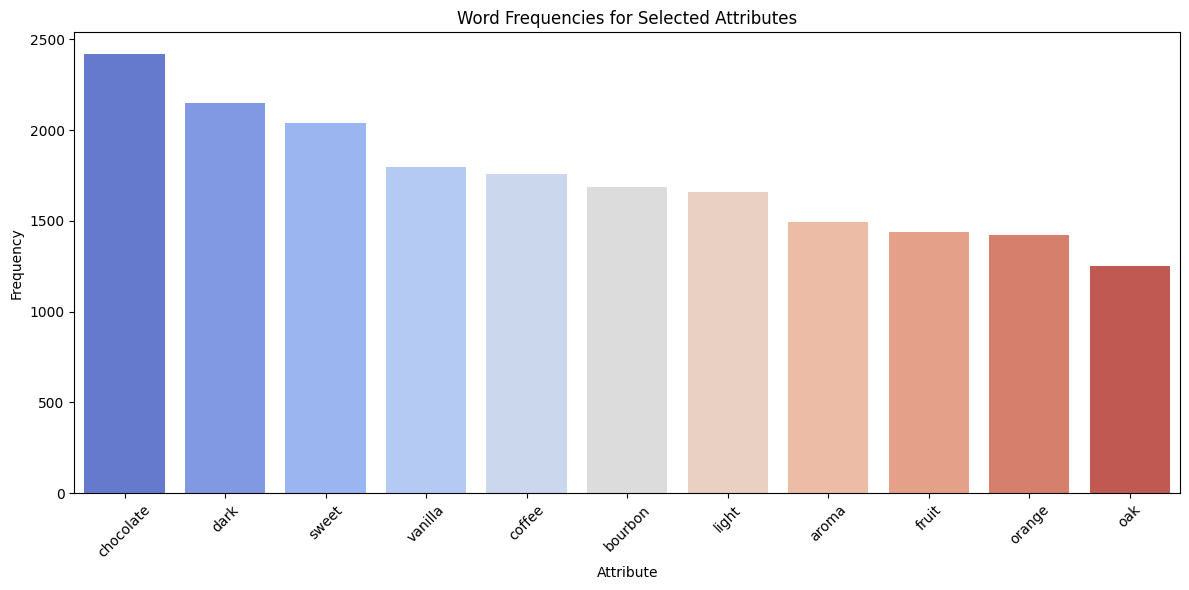

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar chart using Seaborn with 'coolwarm' colormap and vertical bars
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Frequency', data=word_freq_df[word_freq_df['Word'].isin(selected_attributes)], palette='coolwarm')
plt.title('Word Frequencies for Selected Attributes')
plt.xlabel('Attribute')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Reading the user selection file
from google.colab import files
uploaded = files.upload()

Saving User Selection.csv to User Selection.csv


In [ ]:
user_selection=pd.read_csv("User Selection.csv")
print(user_selection)

      Word  Frequency
0     dark        526
1  vanilla        508
2   orange        401


In [ ]:
cos_compare = " ".join(user_selection["Word"])

## **Task C.**
Perform a similarity analysis using cosine similarity (without word embeddings) with the 3 attributes specified by the customer and the reviews.The similarity script should accept as input a file with the product attributes, and calculate similarity scores (between 0 and 1) between these attributes and each review. That is, the output file should have 3 columns – product_name (for each product, the product_name will repeat as many times as there are reviews of the product), product_review and similarity_score.

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import spacy
!python -m spacy download en_core_web_md

# Load the spaCy model
nlp = spacy.load("en_core_web_md")

scraped['processed_review'] = scraped['Review'].apply(
    lambda x: ' '.join([word.text.lower() for word in nlp(x) if word.is_alpha and word.text.lower() not in stop_words])
)

scraped.head()

# Calculate cosine similarity using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(scraped['processed_review'])
Y = vectorizer.transform([cos_compare])
cosine_similarities_countvec = cosine_similarity(X, Y)

# Calculate cosine similarity using spaCy
scraped['cosine_similarity_spacy'] = scraped['processed_review'].apply(
    lambda x: nlp(x).similarity(nlp(cos_compare))
)

# Add cosine similarity values from CountVectorizer to the DataFrame
scraped['cosine_similarity_countvec'] = cosine_similarities_countvec

# Display the DataFrame with both cosine similarity columns
scraped[['Beer', 'Review', 'cosine_similarity_countvec', 'cosine_similarity_spacy']].sort_values("cosine_similarity_countvec", ascending=False)

2023-10-01 23:14:40.484420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 20.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


<ipython-input-10-b1be6a2f0e90>:24: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  lambda x: nlp(x).similarity(nlp(cos_compare))


,Beer,Review,cosine_similarity_countvec,cosine_similarity_spacy
4655,Clare's Thirsty Ale,Pours black with a finger of mocha head.\nSmel...,0.505181,0.839566
5456,Darkness,"Pours luxuriously dark, with bronze caramel an...",0.501280,0.875576
4130,BDCS,L: Dark mahogany with a reddish tint. Slight r...,0.430331,0.836140
2677,Black Tuesday,From the 750 ml bottle in a snifter via Blueja...,0.414698,0.818239
2121,Coffee Cinnamon B-Bomb,8 ounce pour - $10.00 at Woodstock Beer Market...,0.413449,0.809507
...,...,...,...,...
2455,4th Anniversary,4th anniversary re-boot for 8th anniversary.,0.000000,0.072428
2458,4th Anniversary,Poured from a can (2/5) into a Teku\n\nL: soli...,0.000000,0.735133
2459,4th Anniversary,Pure perfection. Fruity and juicy. Tasty and s...,0.000000,0.478924
2461,4th Anniversary,Very cloudy straw appearance with white head t...,0.000000,0.704177


## **Task D.**
For every review, perform a sentiment analysis (using VADER or any LLM). In case you have to change the default values of words in the VADER lexicon, use this article:

https://medium.com/swlh/adding-context-to-unsupervised-sentiment-analysis-7b6693d2c9f8

In [ ]:
sentiment_ratings=[]
prompt_list=[]

## **Using ChatGPT to fetch sentiment scores**

In [ ]:
import os
import openai

openai.api_key = " "


for index, row in scraped.iterrows():
    print(index)
    # Extract the text from the "Review" column
    review_text = row["Review"]

    # Send a request to GPT-3 to rate sentiment
    completion = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "user", "content": "Rate the sentiment of the following text on a scale of 1-5, with 1 being very negative and 5 being very positive, I will be casting this to a float in python, so do not include any other unnecessary text apart from a number from 1 to 5:"+review_text}
        ]
    )

    # Extract and append the sentiment rating (1-5) from GPT-3's response
    sentiment_rating = completion.choices[0].message["content"]
    prompt="Rate the sentiment of the following text on a scale of 1-5, with 1 being very negative and 5 being very positive, I will be casting this to a float in python, so do not include any other unnecessary text apart from a number from 1 to 5:"+review_text
    sentiment_ratings.append(sentiment_rating)
    prompt_list.append(prompt)
    df = pd.DataFrame({'Sentiment_Rating': sentiment_ratings, 'Prompt': prompt_list})

scraped['Sentiment_Rating'], scraped['Prompt'] = df["Sentiment_Rating"], df["Prompt"]

scraped['Sentiment_Rating'] = pd.to_numeric(scraped['Sentiment_Rating'], errors='coerce')
scraped = scraped[~scraped['Sentiment_Rating'].isna()]

In [ ]:
# Reading the file with sentiments from ChatGPT
from google.colab import files
uploaded = files.upload()

Saving checkpoint.csv to checkpoint.csv


In [ ]:
checkpoint=pd.read_csv("checkpoint.csv")
scraped['Sentiment_Rating'], scraped['Prompt'] = checkpoint["Sentiment_Rating"], checkpoint["Prompt"]
scraped['Sentiment_Rating'] = pd.to_numeric(scraped['Sentiment_Rating'], errors='coerce')
scraped = scraped[~scraped['Sentiment_Rating'].isna()]
scraped.head(5)

,Beer,Username,Location,Rating,Review,Date,processed_review,cosine_similarity_spacy,cosine_similarity_countvec,Sentiment_Rating,Prompt
0,Kentucky Brunch Brand Stout,NaN,Hawaii,5/5,"Amazing stout, expensive but worth the price!","Aug 06, 2023",amazing stout expensive worth price,0.330812,0.0000,1.0,Rate the sentiment of the following text on a ...
1,Kentucky Brunch Brand Stout,NaN,Michigan,5/5,This beer meet and exceeded all the unreal hyp...,"Jul 08, 2023",beer meet exceeded unreal hype simply amazing,0.291398,0.0000,2.0,Rate the sentiment of the following text on a ...
2,Kentucky Brunch Brand Stout,NaN,Arkansas,5/5,Let it sit and warm to the room a little ... u...,"May 17, 2023",let sit warm room little unbelievable,0.444795,0.0000,3.0,Rate the sentiment of the following text on a ...
3,Kentucky Brunch Brand Stout,NaN,Colorado,4.67/5,"A small pour, ebony dark, no real head. Intens...","May 12, 2023",small pour ebony dark real head intense rich a...,0.652681,0.1659,3.0,Rate the sentiment of the following text on a ...
4,Kentucky Brunch Brand Stout,NaN,Iowa,5/5,"Vintage 2022, served on tap at Toppling Goliat...","Dec 04, 2022",vintage served tap toppling goliath snulip gla...,0.716661,0.0000,2.5,Rate the sentiment of the following text on a ...


## **Task E.**
Create an evaluation score for each beer that uses both similarity and sentiment scores.

Now **recommend 3 products** to the customer.

In [ ]:
# Recommending 3 products based on cosine similarity
scraped["Combined_Score_bow"]=scraped["cosine_similarity_countvec"]*scraped["Sentiment_Rating"]
reco1=scraped[["Beer","Combined_Score_bow"]].groupby(["Beer"]).mean().reset_index()\
                                        .sort_values(by="Combined_Score_bow",ascending=False)

print(f"""The three recommended Beers based on the user attribute preferences (BOW) are
1.{reco1.iloc[0,0]}
2.{reco1.iloc[1,0]}
3.{reco1.iloc[2,0]}\n""")

# Recommending 3 products based on cosine similarity

scraped["Combined_Score_spacy"]=scraped["cosine_similarity_spacy"]*scraped["Sentiment_Rating"]
reco2=scraped[["Beer","Combined_Score_spacy"]].groupby(["Beer"]).mean().reset_index()\
                                        .sort_values(by="Combined_Score_spacy",ascending=False)

print(f"""The three recommended Beers based on the user attribute preferences (Spacy) are
1.{reco2.iloc[0,0]}
2.{reco2.iloc[1,0]}
3.{reco2.iloc[2,0]}""")

The three recommended Beers based on the user attribute preferences (BOW) are
1.O.W.K.
2.Fundamental Observation
3.Modem Tones - Bourbon Barrel-Aged - Vanilla

The three recommended Beers based on the user attribute preferences (Spacy) are
1.Cellarman Barrel Aged Saison
2.O.W.K.
3.KBS - Maple Mackinac Fudge


## **Task F.**
How would your recommendation change if you use word vectors (e.g., the spaCy package with medium sized pretrained word vectors) instead of the plain vanilla bag-of-words cosine similarity? One way to analyze the difference would be to consider the % of reviews that mention a preferred attribute. E.g., if you recommend a product, what % of its reviews mention an attribute specified by the customer? Do you see any difference across bag-of-words and word vector approaches? Explain. This article may be useful:

 https://medium.com/swlh/word-embeddings-versus-bag-of-words-the-curious-case-of-recommender-systems-6ac1604d4424?source=friends_link&sk=d746da9f094d1222a35519387afc6338

Note that the article doesn’t claim that bag-of-words will always be better than word embeddings for recommender systems. It lays out conditions under which it is likely to be the case. That is, depending on the attributes you use, you may or may not see the same effect.

In [ ]:
reco_check=pd.concat([reco1.head(3),reco2.head(3)],axis=0)
reco_check

,Beer,Combined_Score_bow,Combined_Score_spacy
175,O.W.K.,1.087879,NaN
109,Fundamental Observation,0.877533,NaN
165,Modem Tones - Bourbon Barrel-Aged - Vanilla,0.851150,NaN
52,Cellarman Barrel Aged Saison,NaN,3.287321
175,O.W.K.,NaN,3.273568
140,KBS - Maple Mackinac Fudge,NaN,3.207576


In [ ]:
for word in user_selection.iloc[:,0]:
    scraped[word] = scraped['processed_review'].str.contains(word, case=False).astype(int)

word_freq=scraped[list(user_selection.iloc[:,0])+["Beer"]].groupby("Beer").mean().reset_index()

reco_check.merge(word_freq,how="inner",on="Beer").sort_values(by="Combined_Score_bow")

,Beer,Combined_Score_bow,Combined_Score_spacy,dark,vanilla,orange
3,Modem Tones - Bourbon Barrel-Aged - Vanilla,0.851150,NaN,0.416667,0.833333,0.00
2,Fundamental Observation,0.877533,NaN,0.541667,0.875000,0.00
0,O.W.K.,1.087879,NaN,0.222222,0.888889,0.00
1,O.W.K.,NaN,3.273568,0.222222,0.888889,0.00
4,Cellarman Barrel Aged Saison,NaN,3.287321,0.080000,0.040000,0.16
5,KBS - Maple Mackinac Fudge,NaN,3.207576,0.440000,0.400000,0.00


In [ ]:
temp_df = reco_check.merge(word_freq,how="inner",on="Beer").sort_values(by="Combined_Score_bow")
temp_df["Tag"] = "INT"
temp_df.loc[~temp_df["Combined_Score_bow"].isna(), "Tag"] = "BOW"
temp_df.loc[temp_df["Combined_Score_bow"].isna(), "Tag"] = "Spacy"
aggre=temp_df[["Tag"]+list(user_selection.iloc[:,0])].groupby("Tag").mean().copy(deep=True)
aggre['Row_Average'] = aggre[list(user_selection.iloc[:,0])].mean(axis=1)
aggre

,dark,vanilla,orange,Row_Average
Tag,,,,
BOW,0.393519,0.865741,0.000000,0.419753
Spacy,0.247407,0.442963,0.053333,0.247901


We can see that from the Row_Average value that the frequency of occurence of the user selected attributes is higher in the BOW cosine similarity, this is expected as BOW does a strict word matching compared to spaCy that uses word embedding vectors. Since spaCy embedding cosine simlarity tries to match similar words, one has to ensure that the word embedding vectors are suitable for the activity (beer recommender in this case).
To give an exaample, dark may have different meanings in general day to day use, and may have a different meaning when it comes to beers.

## **Task G.**
How would your recommendations differ if you ignored the similarity and feature sentiment scores and simply chose the 3 highest rated products from your entire dataset? Would these products meet the requirements of the user looking for recommendations? Why or why not? Justify your answer with analysis. Use the similarity and sentiment scores as well as overall ratings to answer this question.

In [ ]:
scraped["Rating"] = pd.to_numeric(scraped["Rating"].str.replace("/5", ""))

In [ ]:
scraped_average = scraped.groupby(["Beer"])["Rating"].agg("mean").sort_values(ascending = False)[:3]
scraped_average

Beer
O.W.K.                                                 4.923333
Kentucky Brunch Brand Stout - Double Barrel Reserve    4.864000
Vanilla Bean Assassin                                  4.834400
Name: Rating, dtype: float64

In [ ]:
bow_scores = scraped.groupby(["Beer"])["Combined_Score_bow"].agg("mean").sort_values(ascending = False)[:3]
bow_scores

Beer
O.W.K.                                         1.087879
Fundamental Observation                        0.877533
Modem Tones - Bourbon Barrel-Aged - Vanilla    0.851150
Name: Combined_Score_bow, dtype: float64

In [ ]:
spacy_scores = scraped.groupby(["Beer"])["Combined_Score_spacy"].agg("mean").sort_values(ascending = False)[:3]
spacy_scores

Beer
Cellarman Barrel Aged Saison    3.287321
O.W.K.                          3.273568
KBS - Maple Mackinac Fudge      3.207576
Name: Combined_Score_spacy, dtype: float64

The recommendations generated by the three different approaches exhibit significant disparities, as demonstrated above. It is clear that relying solely on recommendations based on user ratings would yield generic results, as it neglects the nuanced sentiment conveyed in user reviews. Moreover, there is a plausible scenario where highly-rated beers may not align with the specific attributes of interest to the user.

To obtain more refined and personalized recommendations that account for sentiment analysis and the user's specified attributes, it is advisable to give precedence to recommendations derived from either the Bag of Words (BoW) or cosine similarity methods. These approaches incorporate sentiment analysis from reviews, thereby enhancing the relevance and alignment of the recommendations with the user's preferences. Such an approach ensures a more tailored and satisfactory user experience in the domain of beer recommendations.

##**Task H.**
Using the top four attributes of beer (from word frequency analysis), calculate the lifts between these attributes and any 10 beers in your data. Choose one beer, and find the most similar beer (among the remaining 9) using the lift values. Explain your method.

# Method 1: Cosine Similarity

In [ ]:
# List of 10 random beers
random10Beers = ['Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow',
 'Zenne Y Frontera',
 'Space Trace',
 'Label Us Notorious - Calvados BA Big Poppa',
 'Samuel',
 'Oude Fermier',
 'Abt 12',
 'Hold On To Sunshine',
 'Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged',
 'Very Hazy']

# df with only 10 beers reviews
beersLiftAnalysis = scraped[scraped.Beer.isin(random10Beers)]

# Making a new column by concatenating Beer and review
beersLiftAnalysis['liftText'] = beersLiftAnalysis['Beer'] + ' : ' + beersLiftAnalysis['Review']

<ipython-input-32-122f10ca96a5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beersLiftAnalysis['liftText'] = beersLiftAnalysis['Beer'] + ' : ' + beersLiftAnalysis['Review']


In [ ]:
df_lift = beersLiftAnalysis[['Beer','Review']]
# Tokenizing the words in messages
df_lift['Tokens'] = df_lift['Review'].apply(nltk.word_tokenize)

# should we lemmatize words?, like dark, darker, darkest all these mentions would be similar
#lemmatizer = WordNetLemmatizer()

# Define a function to cleanse the tokens
def cleanse_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    # Remove stop words, non-alphanumeric tokens, and punctuation
    cleansed_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.isalnum() and token not in punctuation]

    return cleansed_tokens

# Apply the cleansing function to the 'Tokens' column
df_lift['Cleansed'] = df_lift['Tokens'].apply(cleanse_tokens)

<ipython-input-33-c9a49ae7e7b8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lift['Tokens'] = df_lift['Review'].apply(nltk.word_tokenize)
<ipython-input-33-c9a49ae7e7b8>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lift['Cleansed'] = df_lift['Tokens'].apply(cleanse_tokens)


In [ ]:
from itertools import product

beers_list = list(beersLiftAnalysis['Beer'].unique()[:10])
attributes = ['head', 'chocolate', 'dark', 'notes']
combi = list(product(beers_list, attributes))
df_brand_attr = pd.DataFrame(combi, columns=["Beer", "Attribute"])
df_brand_attr.head(5)

,Beer,Attribute
0,Zenne Y Frontera,head
1,Zenne Y Frontera,chocolate
2,Zenne Y Frontera,dark
3,Zenne Y Frontera,notes
4,Very Hazy,head


In [ ]:
# Initialize an empty DataFrame to store results
result_columns = ['Beer', 'Attribute', 'Beer_Count', 'Attribute_Count', 'Beer_Attribute_Cooccurrence_Count', 'Total_Messages']
result_df2 = pd.DataFrame(columns=result_columns)
total_messages = len(df_lift)

# Loop through all combinations of brands
for brand_pair in df_brand_attr.itertuples(index=False):
    brand, attr = brand_pair
    #print(brand)
    # Initialize Counters and Position Tracker
    count_brand = 0
    count_attr = 0
    count_cooccurrence = 0

    # Loop over messages
    for beer,tokens in df_lift[['Beer','Tokens']].itertuples(index=False):
        # Check total messages with Brand1
        if brand in beer:
            count_brand += 1

        # Check total messages with Brand2
        if attr in tokens:
            count_attr += 1

        # Check for Co-occurrence within the same message (not more than 5 tokens apart)
        if (brand in beer) & (attr in tokens):
            count_cooccurrence += 1

    # Append results to the DataFrame
    result_df2 = pd.concat([result_df2, pd.DataFrame({'Beer': [brand], 'Attribute': [attr],
                                  'Beer_Count': [count_brand],
                                  'Attribute_Count': [count_attr],
                                  'Beer_Attribute_Cooccurrence_Count': [count_cooccurrence],
                                  'Total_Messages': [total_messages]})],
                          ignore_index=True)

result_df2["lift"]=(result_df2["Beer_Attribute_Cooccurrence_Count"]/result_df2["Total_Messages"])/((result_df2["Beer_Count"]/result_df2["Total_Messages"])*(result_df2["Attribute_Count"]/result_df2["Total_Messages"]))
pivot_table = result_df2.pivot_table(index='Beer', columns='Attribute', values='lift')

In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

beers = pivot_table.index
# Compute cosine similarities
similarities = cosine_similarity(pivot_table)

# Convert the results into a DataFrame for better visualization
similarity_df = pd.DataFrame(similarities, index=beers, columns=beers)

similarity_df

Beer,Abt 12,Hold On To Sunshine,Label Us Notorious - Calvados BA Big Poppa,Oude Fermier,Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow,Samuel,Space Trace,Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged,Very Hazy,Zenne Y Frontera
Beer,,,,,,,,,,
Abt 12,1.000000,0.591081,0.853523,0.840161,0.684819,0.750681,0.741235,0.742009,0.543110,0.897057
Hold On To Sunshine,0.591081,1.000000,0.920829,0.290805,0.944766,0.274999,0.957795,0.969708,0.358024,0.226493
Label Us Notorious - Calvados BA Big Poppa,0.853523,0.920829,1.000000,0.557404,0.942820,0.494525,0.978599,0.980696,0.429333,0.567417
Oude Fermier,0.840161,0.290805,0.557404,1.000000,0.396045,0.983353,0.388591,0.433014,0.820892,0.932679
Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow,0.684819,0.944766,0.942820,0.396045,1.000000,0.351368,0.975783,0.983363,0.305048,0.403159
Samuel,0.750681,0.274999,0.494525,0.983353,0.351368,1.000000,0.325672,0.385316,0.901554,0.854372
Space Trace,0.741235,0.957795,0.978599,0.388591,0.975783,0.325672,1.000000,0.994992,0.282740,0.415332
Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged,0.742009,0.969708,0.980696,0.433014,0.983363,0.385316,0.994992,1.000000,0.362388,0.427469
Very Hazy,0.543110,0.358024,0.429333,0.820892,0.305048,0.901554,0.282740,0.362388,1.000000,0.561607


In [ ]:
#Taking Very Hazy beer as an example
similarity_df[similarity_df.index!='Very Hazy'][['Very Hazy']].sort_values('Very Hazy', ascending = False)

### Approach to Recommend Beers Using Lift Scores:

* **We've selected the following 10 beers**:

| Beer Name |
|-----------|
| Popinski - Bourbon Barrel-Aged - Peanut Butter And Marshmallow |
| Zenne Y Frontera |
| Space Trace |
| Label Us Notorious - Calvados BA Big Poppa |
| Samuel |
| Oude Fermier |
| Abt 12 |
| Hold On To Sunshine |
| Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged |
| Very Hazy |

* **We've focused on the following 4 attributes**:

| Attr1 | Attr2 | Attr3 | Attr4 |
|-------|-------|-------|-------|
| head  | chocolate | dark | notes |

* **Data Filtering**:
    - We filtered the master dataframe to only include rows containing these 10 beers and their reviews. This gave us a new dataframe named `beersLiftAnalysis`.

* **Lift Calculation for Beer-Attribute Combination**:
    - We iterated through the combinations of beer-attribute and computed the following for every combination:
        * Count of beer mentions (`Beer_Count`)
        * Count of attribute mentions (`Attribute_Count`)
        * Count of co-occurrences where both the beer and attribute are mentioned together (`Beer_Attribute_Cooccurrence_Count`)
        * Total number of messages or reviews (`Total_Messages`)
        * The lift score, which measures the association between the beer and the attribute.

    For instance:
    
| Beer | Attribute | Beer_Count | Attribute_Count | Beer_Attribute_Cooccurrence_Count | Total_Messages | lift |
|------|-----------|------------|-----------------|----------------------------------|----------------|------|
| Speedway Stout - Vietnamese Coffee - Bourbon-Barrel Aged | chocolate | 25 | Varies | Varies | 234 | 2.866667 |

* **Constructing a Matrix**:
    - Using the computed lift values, we crafted a matrix (`pivot_table`). Each row corresponds to a beer, and each column corresponds to an attribute. The matrix entries are the lift values, capturing how each beer relates to the top attributes.

* **Cosine Similarity Calculation for Beer Recommendations**:
    - By treating each row of the matrix as a vector, we applied the cosine similarity metric. The result was a `similarity_df` matrix, where each row and column represents a beer. The matrix entries show the similarity score between the beers based on their association with the attributes.

* **Identifying the Most Similar Beer**:
    - For a selected beer (e.g., "Very Hazy"), we inspected its corresponding row or column in the `similarity_df` matrix to obtain the similarity scores with all other beers. Sorting these scores in descending order, we identified the most similar beers. In our case, "Samuel" was found to be the most similar to "Very Hazy".

# Method 2: Bucketing

In [ ]:
from itertools import product

beers_list = list(scraped['Beer'].unique()[:10])
attributes = ['sweet','dark','light','fruit']
combi = list(product(beers_list, attributes))
df_brand_attr = pd.DataFrame(combi, columns=["Beer", "Attribute"])
df_brand_attr.head(5)

,Beer,Attribute
0,Kentucky Brunch Brand Stout,sweet
1,Kentucky Brunch Brand Stout,dark
2,Kentucky Brunch Brand Stout,light
3,Kentucky Brunch Brand Stout,fruit
4,Vanilla Bean Assassin,sweet


In [ ]:
df_lift = scraped[['Beer','Review']]
df_lift = df_lift[df_lift['Beer'].isin(beers_list)]
# Tokenizing the words in messages
df_lift['Tokens'] = df_lift['Review'].apply(nltk.word_tokenize)

# should we lemmatize words?, like dark, darker, darkest all these mentions would be similar
#lemmatizer = WordNetLemmatizer()

# Define a function to cleanse the tokens
def cleanse_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    # Remove stop words, non-alphanumeric tokens, and punctuation
    cleansed_tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token.isalnum() and token not in punctuation]

    return cleansed_tokens

# Apply the cleansing function to the 'Tokens' column
df_lift['Cleansed'] = df_lift['Tokens'].apply(cleanse_tokens)

In [ ]:
# Initialize an empty DataFrame to store results
result_columns = ['Beer', 'Attribute', 'Beer_Count', 'Attribute_Count', 'Beer_Attribute_Cooccurrence_Count', 'Total_Messages']
result_df2 = pd.DataFrame(columns=result_columns)
total_messages = len(df_lift)

# Loop through all combinations of brands
for brand_pair in df_brand_attr.itertuples(index=False):
    brand, attr = brand_pair
    #print(brand)
    # Initialize Counters and Position Tracker
    count_brand = 0
    count_attr = 0
    count_cooccurrence = 0

    # Loop over messages
    for beer,tokens in df_lift[['Beer','Tokens']].itertuples(index=False):
        # Check total messages with Brand1
        if brand in beer:
            count_brand += 1

        # Check total messages with Brand2
        if attr in tokens:
            count_attr += 1

        # Check for Co-occurrence within the same message (not more than 5 tokens apart)
        if (brand in beer) & (attr in tokens):
            count_cooccurrence += 1

    # Append results to the DataFrame
    result_df2 = pd.concat([result_df2, pd.DataFrame({'Beer': [brand], 'Attribute': [attr],
                                  'Beer_Count': [count_brand],
                                  'Attribute_Count': [count_attr],
                                  'Beer_Attribute_Cooccurrence_Count': [count_cooccurrence],
                                  'Total_Messages': [total_messages]})],
                          ignore_index=True)

result_df2["lift"]=(result_df2["Beer_Attribute_Cooccurrence_Count"]/result_df2["Total_Messages"])/((result_df2["Beer_Count"]/result_df2["Total_Messages"])*(result_df2["Attribute_Count"]/result_df2["Total_Messages"]))

In [ ]:
result_df2.head()

,Beer,Attribute,Beer_Count,Attribute_Count,Beer_Attribute_Cooccurrence_Count,Total_Messages,lift
0,Kentucky Brunch Brand Stout,sweet,25,49,0,233,0.0
1,Kentucky Brunch Brand Stout,dark,25,37,4,233,1.007568
2,Kentucky Brunch Brand Stout,light,25,22,6,233,2.541818
3,Kentucky Brunch Brand Stout,fruit,25,12,2,233,1.553333
4,Vanilla Bean Assassin,sweet,25,49,4,233,0.760816


In [ ]:
pivot_table = result_df2.pivot_table(
    values='lift',   # Values to aggregate
    index='Beer',  # Rows in the pivot table
    columns='Attribute',      # Optional: Columns in the pivot table
    aggfunc='max',    # Aggregation function (e.g., 'mean', 'sum', 'count')
)

for column in pivot_table.columns:
  buckets = pd.qcut(pivot_table[column], q=[0,0.33,0.66,1], labels=False, duplicates='drop')
  col_name = str(column) + '_bucket'
  pivot_table[col_name] = buckets +1

pivot_table

Attribute,dark,fruit,light,sweet,dark_bucket,fruit_bucket,light_bucket,sweet_bucket
Beer,,,,,,,,
Abraxas - Barrel-Aged,1.511351,0.000000,0.000000,0.760816,3,1,1,1
Blessed,1.836712,0.809028,1.323864,1.585034,3,2,3,3
Heady Topper,0.503784,0.776667,0.847273,0.760816,1,2,2,1
Hunahpu's Imperial Stout - Double Barrel Aged,1.259459,0.776667,0.423636,1.141224,3,2,1,3
Kentucky Brunch Brand Stout,1.007568,1.553333,2.541818,0.000000,2,3,3,1
King Julius,0.755676,3.106667,1.270909,0.951020,2,3,3,2
Marshmallow Handjee,0.755676,0.000000,1.270909,1.331429,2,1,3,3
Mornin' Delight,0.251892,0.000000,0.423636,1.902041,1,1,1,3
O.W.K.,0.699700,2.157407,1.176768,0.528345,1,3,2,1


In [ ]:
# Suppose I want to choose Vanilla Bean Assassin

chosen_beer = 'Blessed'


buckets = ['dark_bucket','fruit_bucket','light_bucket','sweet_bucket']
matches_list = []

for bucket in buckets:
    value_to_find = pivot_table.loc[chosen_beer,bucket]
    # Taking only the dark_bucket
    stacked = pivot_table[pivot_table.index != chosen_beer][bucket]
    # Finding all the beers with same bucket
    matches_list.append(list(stacked[stacked == value_to_find].index))

# Flatten the list of lists into a single list
flattened_data = [item for sublist in matches_list for item in sublist]
# Use Counter to count the occurrences of each element
element_counts = Counter(flattened_data)

print(element_counts)

# Find the most occurring element
most_common_element = max(element_counts, key=element_counts.get)
# Print the most occurring element and its count
print("Recommended beer:", most_common_element)

Counter({"Hunahpu's Imperial Stout - Double Barrel Aged": 3, 'Marshmallow Handjee': 2, 'Abraxas - Barrel-Aged': 1, 'Vanilla Bean Assassin': 1, 'Heady Topper': 1, 'Kentucky Brunch Brand Stout': 1, 'King Julius': 1, "Mornin' Delight": 1})
Recommended beer: Hunahpu's Imperial Stout - Double Barrel Aged


Approach to recommend beers using lift scores:

* We've selected the following 10 beers:

| Beer Name                                    |
|---------------------------------------------|
| Abraxas - Barrel-Aged                       |
| Blessed                                     |
| Heady Topper                                |
| Hunahpu's Imperial Stout - Double Barrel Aged|
| Kentucky Brunch Brand Stout                 |
| King Julius                                 |
| Marshmallow Handjee                        |
| Mornin' Delight                            |
| O.W.K.                                      |
| Vanilla Bean Assassin                      |

* We've selected the following 4 attributes:

|Attr1|Attr2|Attr3|Attr4|
| --- | --- | --- | ---- |
| sweet | dark | light | fruit |

* We filtered the master datafrane for only the rows containing these 10 beers and their reviews, which gives us a new dataframe of 234 rows

* We next iterated through the combinations of beer-attributre and computed the following for everycombination:

| Beer                       | Attribute | Beer_Count | Attribute_Count | Beer_Attribute_Cooccurrence_Count | Total_Messages | lift |
|----------------------------|-----------|------------|-----------------|----------------------------------|----------------|------|
|Kentucky Brunch Brand Stout|light|25|22|6|234|2.552727|

* For a given attribute of beer, we divided the lift scores into 3 buckets (lift of 0 is NaN)

| Beer                                 | dark_bucket |
|--------------------------------------|-------------|
| Abraxas - Barrel-Aged                | 3           |
| Blessed                              | 3           |
| Heady Topper                         | 2           |
| Hunahpu's Imperial Stout - Double Barrel Aged | 3 |
| Kentucky Brunch Brand Stout          | 3           |
| King Julius                          | 2           |
| Marshmallow Handjee                  | 2         |
| Mornin' Delight                      | NaN         |
| O.W.K.                               | 2           |
| Vanilla Bean Assassin                | 3           |


* Now for a selected beer, say 'Kentucky Brunch Brand Stout', which has got the following in attribute buckets:

| dark_bucket | fruit_bucket | light_bucket | sweet_bucket |
|------|-------|-------|-------|
| 3    | 2     | 3     | NaN   |

* The closest match is 'Vanilla Bean Assassin'

| dark_bucket | fruit_bucket | light_bucket | sweet_bucket |
|------|-------|-------|-------|
| 3    | 2     | 1     | 2   |

Which has two buckets matching with 'Kentucky Brunch Brand Stout', rest all have 1 or less buckets matching
